# Creating a simple CNN

This model has only a few layers, and does not make use of additional information (e.g. distance).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print('Changed directory to', os.getcwd())

Changed directory to E:\workspace\morpho-mstar


# Load data

In [2]:
from morphoml import load_npy

dsets = ['train', 'val', 'test']
npix = 69
ntrain = 10000
d_data = {}

for dset in dsets:
    d_data[dset] = {}
    imgs, names = load_npy(dset, npix=npix, ntrain=10000)
    d_data[dset]['imgs'] = np.expand_dims(imgs, axis=-1)
    d_data[dset]['names'] = names

In [3]:
print(d_data['train']['imgs'].shape, d_data['val']['imgs'].shape, d_data['test']['imgs'].shape,
      d_data['train']['imgs'].dtype)
# Each image is scaled to [-1, 1]
print(np.min(d_data['train']['imgs'][0, :]), np.max(d_data['train']['imgs'][0, :]))
# Names contains a unique 64-bit identifier for each galaxy (called "objid")
print(d_data['train']['names'].shape, d_data['train']['names'].dtype)
d_data['train']['names'][:5]

(10000, 69, 69, 1) (2500, 69, 69, 1) (5000, 69, 69, 1) float32
-1.0 1.0
(10000,) int64


array([1237657611265507490, 1237661852004253738, 1237662305125204183,
       1237659324942712960, 1237657858221801565], dtype=int64)

In [4]:
# The metadata is indexed by the objid
df_meta = pd.read_csv('./data/metadata/metadata.tsv', sep='\t', index_col=0)
print(df_meta.shape)
df_meta.head()

(73627, 4)


,M/L,L_g,distance_Mpc,galsize_kpc
SDSS_ID,,,,
1237662301367173202,2.398229,8.880467e+09,326.142854,48.655727
1237662301905813735,0.974585,7.007162e+09,293.571417,38.145197
1237662534360301834,0.678322,1.047446e+10,167.142861,30.677076
1237662500543987740,1.574709,1.748155e+10,282.000016,46.129129
1237662474235085097,1.076603,9.267565e+09,291.857134,43.540800


In [5]:
for dset in dsets:
    d_data[dset]['M/L'] = df_meta.loc[d_data[dset]['names'], 'M/L'].values

# Build and train model

In [6]:
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(npix, npix, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         1

In [7]:
# Create datasets
import tensorflow_addons as tfa

batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

for dset in dsets:
    d_data[dset]['xy_dataset'] = tf.data.Dataset.from_tensor_slices(
                                        (d_data[dset]['imgs'], d_data[dset]['M/L'])
                                )

def convert_image(image):
    # Cast and normalize the image to [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def augment_image(image):
    add_pix = 10
    npix = image.shape[1]
    image = convert_image(image)
    # to [0, 2], since it automatically pads with zeros
    image = image + 1
    # Add padding (to translate later)
    image = tf.image.resize_with_crop_or_pad(image, npix + add_pix, npix + add_pix)
    # Rotate all images in batch with same, uniformly chosen angle
    random_angles = tf.random.uniform(shape = (), minval=-np.pi, maxval=np.pi)
    image = tfa.image.rotate(image, random_angles)
    # Crop back to needed format
    image = tf.image.random_crop(image, size=[npix, npix, 1]) # Random crop back
    image = image - 1
    return image

def convert(image, label): return convert_image(image), label
def augment(image, label): return augment_image(image), label

augmented_train_batches = (
     d_data['train']['xy_dataset']
        .cache()
        .shuffle(ntrain // 4)
        .map(augment, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
)
validation_batches = (
     d_data['val']['xy_dataset']
        .map(convert, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
)

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

nepochs = 100
callbacks = [tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=6,
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3,
                                                  min_delta=1e-4, verbose=1)]
history = model.fit(augmented_train_batches, 
                    validation_data=validation_batches,
                    epochs=nepochs, 
                    callbacks=callbacks)

Train for 313 steps, validate for 79 steps
Epoch 1/100
313/313 [==============================] - 6s 20ms/step - loss: 1.4681 - mse: 1.4687 - val_loss: 1.1937 - val_mse: 1.1871
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 1.2238 - mse: 1.2230 - val_loss: 1.2961 - val_mse: 1.2921
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 1.1552 - mse: 1.1560 - val_loss: 1.2933 - val_mse: 1.2880
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 1.1025 - mse: 1.1027 - val_loss: 1.0789 - val_mse: 1.0725
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0441 - mse: 1.0435 - val_loss: 1.0834 - val_mse: 1.0753
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0010 - mse: 1.0012 - val_loss: 0.9892 - val_mse: 0.9809
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.9805 - mse: 0.9814 - val_loss: 1.0235 - val_mse: 1.0167
Epoch 8/100
313/313

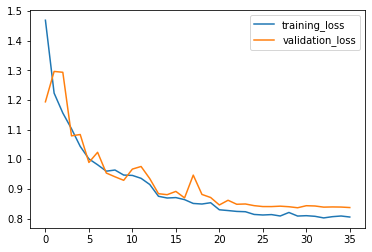

In [9]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='training_loss')
plt.plot(history_df['val_loss'], label='validation_loss')
_ = plt.legend()

In [10]:
for dset in dsets:
    d_data[dset]['y_pred'] = model.predict(d_data[dset]['xy_dataset']
                                            .map(convert, num_parallel_calls=AUTOTUNE)
                                            .batch(batch_size)).squeeze()

# Check results

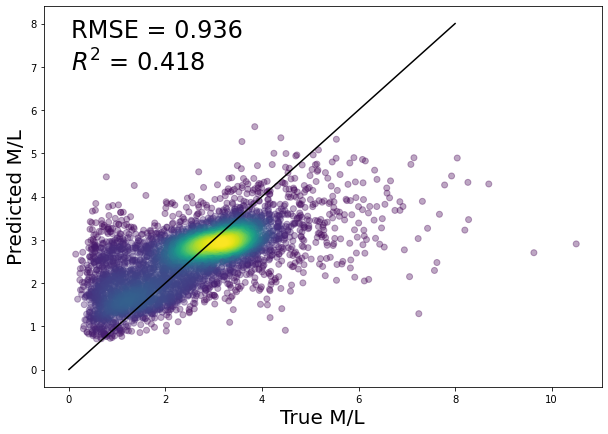

In [11]:
def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred(dset='test'):
    y = d_data[dset]['M/L']
    y_pred = d_data[dset]['y_pred']
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()